In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewnorm
from scipy import stats
import asymNdimPdf as apdf

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [3]:
cov = [
    [ 1.0000, -0.5831,  0.3043, -0.0947],
    [-0.5831,  1.0000, -0.8086,  0.3408],
    [ 0.3043, -0.8086,  1.0000, -0.6537],
    [-0.0947,  0.3408, -0.6537,  1.0000],
]

In [4]:
measList = np.abs(np.array([
    [294294486.30765355, 13772753.716775, 13772753.71677],
    [1422794304.2929785, 24824720.888811827, 24824720.888811827],
    [1267269574.642189 , 25123416.917518854, 25123416.917518854],
    [189906179.52377066, 12954766.704744637, 12954766.704744607],
]))/1e6

In [5]:
snParams = []
for m in measList:
    #snParams.append(apdf.paramFromMeas(m[0], m[2], m[1]))
    snParams.append([m[0], m[2], 0])
    print(snParams[-1])

[294.29448630765353, 13.772753716770001, 0]
[1422.7943042929785, 24.824720888811825, 0]
[1267.2695746421891, 25.123416917518853, 0]
[189.90617952377065, 12.954766704744607, 0]


In [6]:
# N-dim PDF
loc, scale, alpha = [], [], []
for p in snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])

ndSN = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=alpha)

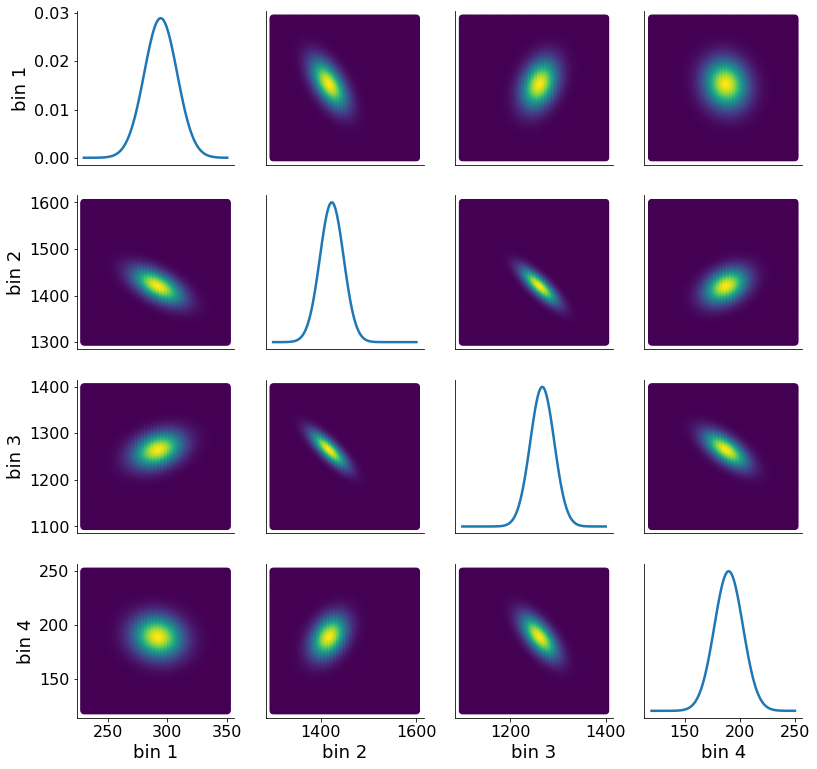

In [7]:
borders = [ 
           [ 230,  350], 
           [1300, 1600],
           [1100, 1400],
           [ 120,  250],
         ]

varName = ['bin 1', 'bin 2', 'bin 3', 'bin 4']

# Plotting each variable pair
ndSN.plot(varNames=varName, borders=borders, nPoints=100, contour=False)

In [8]:
def getToysGaussian(n):
    '''
    Sampling based on gaussians PDFs
    '''
    
    Xs = []
    loc, scale = [], []
    for m in measList:
        loc.append(m[0])
        scale.append(max(m[1], m[2])*3)
        
    covM = np.zeros(shape=(4, 4))
    for i in range(4):
        for j in range(4):
            s1, s2 = scale[i], scale[j]
            covM[i][j] = cov[i][j] * s1 * s2
    
    Xs = np.random.multivariate_normal(mean=loc, cov=covM, size=n)
    Ys = np.random.rand(n) * np.max(ndSN.pdf(Xs))

    return Xs[ndSN.pdf(Xs)>=Ys]


def getNtoysGauss(nMin, chunck=100000):
    '''
    Specify the wanted number of toys.
    '''
    nToys, data = 0, []
    while nToys<nMin:
        data.append(getToysGaussian(n=chunck))
        nToys += data[-1].shape[0]
    return np.concatenate(data)


def getNtoysFlat(nMin, chunck=100000):
    '''
    Specify the wanted number of toys.
    '''
    
    bordersToys = [ [m[0]-6*m[1], m[0]+6*m[2]] for m in measList ]    
    nToys, data = 0, []
    while nToys<nMin:
        data.append(apdf.generateData(ndSN.pdf, n=chunck, borders=bordersToys))
        nToys += data[-1].shape[0]
    return np.concatenate(data)

In [9]:
dataG = getNtoysFlat(100000)
print(dataG.shape)

(100044, 4)


In [15]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
CkkG = -9 * np.sum(dataG*w, axis=1) / np.sum(dataG, axis=1)

In [16]:
alpha, loc, scale = skewnorm.fit(CkkG, fa=0)

In [17]:
locG, scaleG = stats.norm.fit(CkkG)

0.3322  -0.0315  +0.0315
0.3322  -0.0317  +0.0317
0.3322039729171936 0.031683137140640014 0


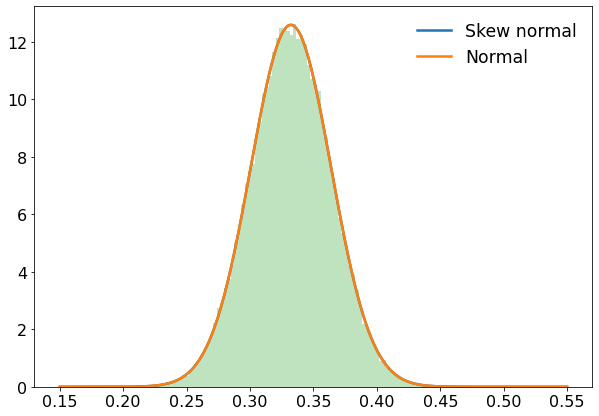

In [18]:
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
ga = stats.norm(loc=locG, scale=scaleG).pdf
x = np.linspace(0.15, 0.55, 1000)
plt.plot(x, sn.pdf(x), label='Skew normal')
plt.plot(x, ga(x), label='Normal')
plt.hist(CkkG, bins=100, density=True, alpha=0.3)
plt.legend();
print('{:.4f}  -{:.4f}  +{:.4f}'.format(*sn.measAsymError()))
print('{:.4f}  -{:.4f}  +{:.4f}'.format(locG, scaleG, scaleG))
print(loc, scale, alpha)

In [63]:
bordersToys = [ 
           [ 230,  350], 
           [1300, 1500],
           [1150, 1400],
           [ 120,  250],
         ]
data = apdf.generateData(ndSN.pdf, n=9000000, borders=bordersToys)
print(data.shape)

(16550, 4)


In [50]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(data*w, axis=1) / np.sum(data, axis=1)

In [64]:
alpha, loc, scale = skewnorm.fit(Ckk)

0.3343  -0.0326  +0.0321


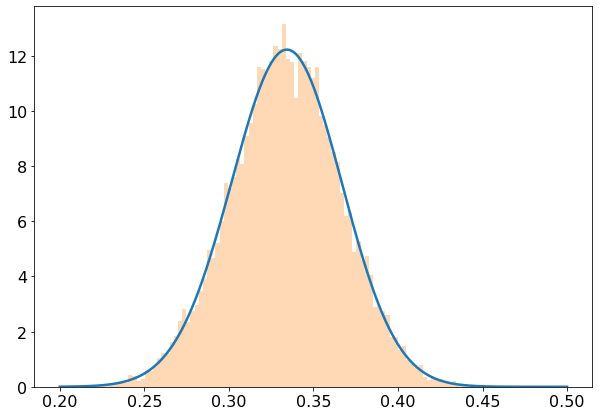

In [66]:
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x = np.linspace(0.2, 0.5, 1000)
plt.plot(x, sn.pdf(x))
plt.hist(Ckk, bins=100, density=True, alpha=0.3);
print('{:.4f}  -{:.4f}  +{:.4f}'.format(*sn.measAsymError()))

0.3322  -0.0316  +0.0316


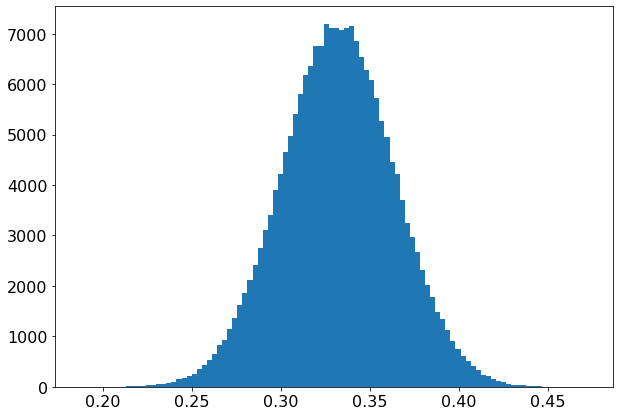

In [140]:
loc, scale = [], []
for m in measList:
    loc.append(m[0])
    scale.append(m[1])

covM = np.zeros(shape=(4, 4))
for i in range(4):
    for j in range(4):
        s1, s2 = scale[i], scale[j]
        covM[i][j] = cov[i][j] * s1 * s2

data = np.random.multivariate_normal(mean=loc, cov=covM, size=200000)
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(data*w, axis=1) / np.sum(data, axis=1)
locG, scaleG = stats.norm.fit(Ckk)
plt.hist(Ckk, bins=100);
print('{:.4f}  -{:.4f}  +{:.4f}'.format(locG, scaleG, scaleG))